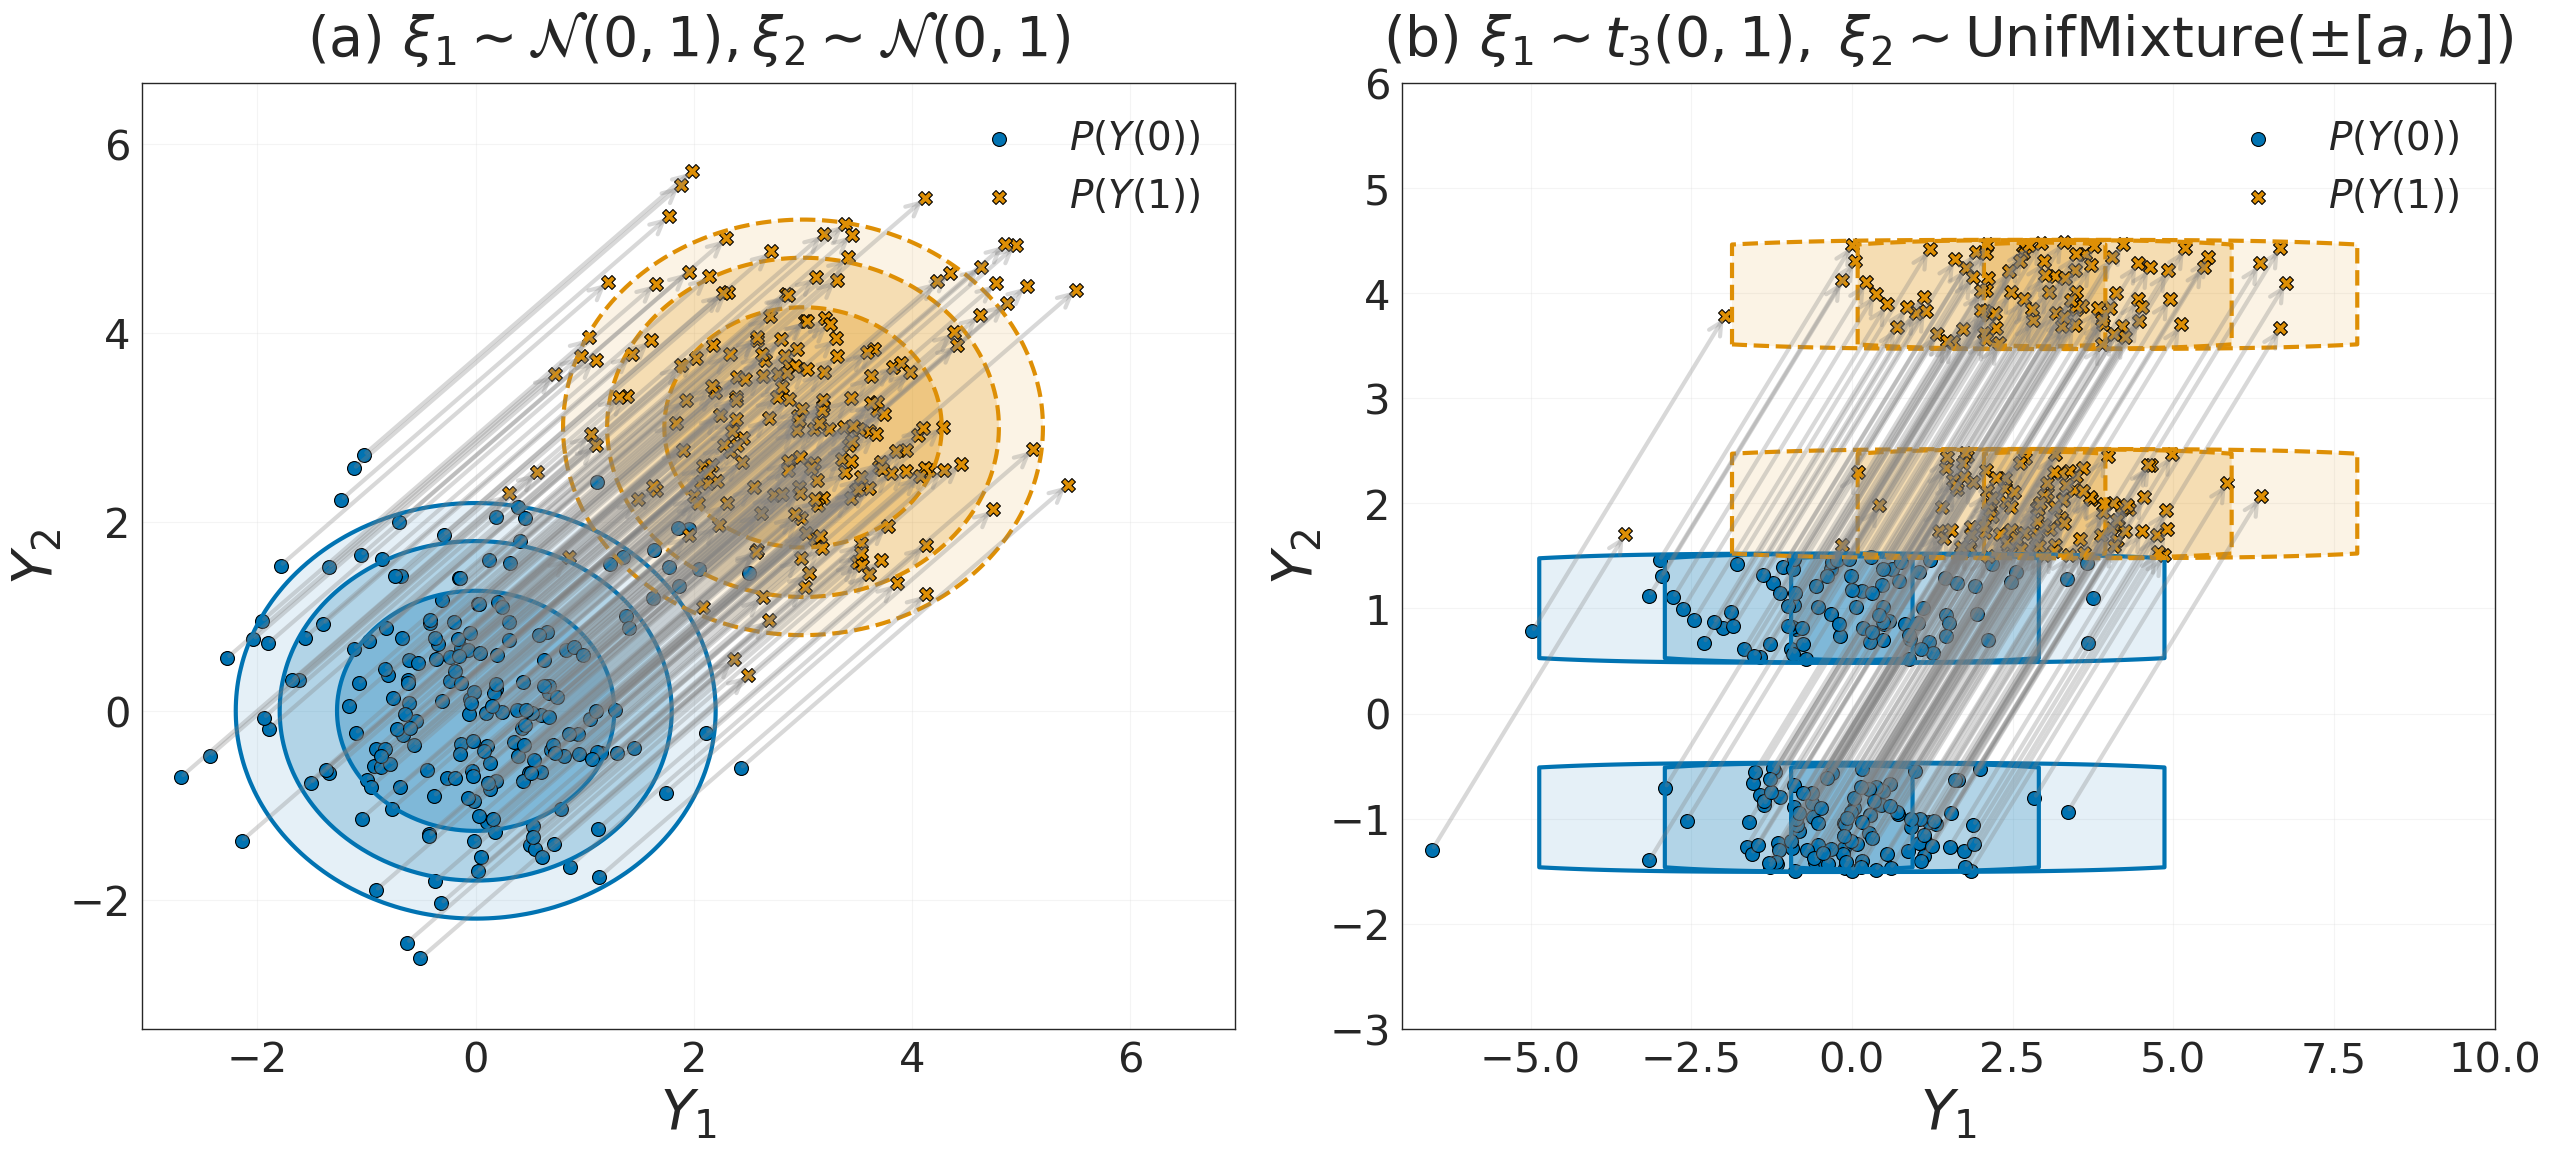

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, t

# Suppress font_manager messages
import logging
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

# Seaborn style and colour‐blind palette
sns.set_style("white")
sns.set_context("paper", font_scale=2.4)
palette = sns.color_palette("colorblind", 2)

# -------------------------------  data  -------------------------------------
np.random.seed(1)
n_big, n_scatter = 1000, 200

# Linear map A (2×1)
A = np.array([[0.3], [0.3]])
A1, A2 = A[0,0], A[1,0]

delta = 10.0  # shift from x=0 to x=10
df = 3

# --- noise case (a): both coordinates Gaussian ---------------------------
U1 = np.random.normal(0, 1, size=n_big)
U2 = np.random.normal(0, 1, size=n_big)
Y0_norm = np.column_stack([U1, U2])  # Y at x=0
Y10_norm = Y0_norm + delta * A.T     # Y at x=10

# --- noise case (b): coord1 Student-t, coord2 mixture of uniforms -------
U1_b = np.random.standard_t(df=df, size=n_big)
flip = np.random.rand(n_big) < 0.5
a, b = -1.5, -0.5
c, d = 0.5, 1.5
U2_b = np.where(
    flip,
    np.random.uniform(a, b, size=n_big),
    np.random.uniform(c, d, size=n_big)
)
Y0_mix = np.column_stack([U1_b, U2_b])  # Y at x=0
Y10_mix = Y0_mix + delta * A.T          # Y at x=10

# helper: equal spans per panel
def get_limits(Y0, Y1, pad=0.0):
    y1_min = min(Y0[:,0].min(), Y1[:,0].min()) - pad
    y1_max = max(Y0[:,0].max(), Y1[:,0].max()) + pad
    y2_min = min(Y0[:,1].min(), Y1[:,1].min()) - pad
    y2_max = max(Y0[:,1].max(), Y1[:,1].max()) + pad
    span = max(y1_max - y1_min, y2_max - y2_min)
    mid1 = 0.5*(y1_max + y1_min)
    mid2 = 0.5*(y2_max + y2_min)
    return mid1 - span/2, mid1 + span/2, mid2 - span/2, mid2 + span/2

lims_norm = get_limits(Y0_norm, Y10_norm)
lims_mix  = get_limits(Y0_mix,  Y10_mix)

# random subset for arrows
idx = np.random.choice(n_big, n_scatter, replace=False)

# -----------------------------  analytic densities  -------------------------
def pdf_norm(y1, y2):
    return norm.pdf(y1) * norm.pdf(y2)

def pdf_mix(y1, y2):
    # mixture of uniforms on [a,b] and [c,d]
    uni1 = ((y2 >= a) & (y2 <= b)) / (b - a)
    uni2 = ((y2 >= c) & (y2 <= d)) / (d - c)
    mix_uni = 0.5 * uni1 + 0.5 * uni2
    return t.pdf(y1, df=df) * mix_uni

# -----------------------------  plotting  -----------------------------------
def make_panel(ax, Y0, Y1, pdf_fn, title, arrow_idx, limits, q_levels):
    y1_min, y1_max, y2_min, y2_max = limits
    y1g, y2g = np.mgrid[y1_min:y1_max:200j, y2_min:y2_max:200j]
    z0 = pdf_fn(y1g, y2g)
    z1 = pdf_fn(y1g - delta*A1, y2g - delta*A2)

    # compute quantile-based contours
    levels0 = np.quantile(z0.ravel(), q_levels)
    levels1 = np.quantile(z1.ravel(), q_levels)
    alphas = [0.1, 0.3, 0.5]

    for data, color, ls, levels in [
        (z0, palette[0], 'solid', levels0),
        (z1, palette[1], 'dashed', levels1)
    ]:
        for i in range(len(levels)):
            low = levels[i]
            high = levels[i+1] if i < len(levels)-1 else np.nanmax(data)
            ax.contourf(y1g, y2g, data, levels=[low, high],
                        colors=[color], alpha=alphas[i], antialiased=True)
        ax.contour(y1g, y2g, data, levels=levels,
                   colors=[color], linestyles=ls, linewidths=3)

    ax.scatter(Y0[arrow_idx,0], Y0[arrow_idx,1],
               color=palette[0], s=100,
               label=r'$P(Y(0))$', edgecolor='black')
    ax.scatter(Y1[arrow_idx,0], Y1[arrow_idx,1],
               color=palette[1], s=100, marker='X',
               label=r'$P(Y(1))$', edgecolor='black')
    for i in arrow_idx:
        ax.annotate('', xy=(Y1[i,0],Y1[i,1]),
                    xytext=(Y0[i,0],Y0[i,1]),
                    arrowprops=dict(arrowstyle='->',
                                    color='grey', lw=3, alpha=0.3))

    ax.set_xlim(limits[0], limits[1])
    ax.set_ylim(limits[2], limits[3])
    ax.set_title(title, fontsize=40, pad=20)
    ax.set_xlabel(r'$Y_1$', fontsize=40)
    ax.set_ylabel(r'$Y_2$', fontsize=40)
    ax.tick_params(labelsize=30)
    ax.grid(alpha=0.2)
    ax.legend(fontsize=28, frameon=False)

fig, axes = plt.subplots(1, 2, figsize=(26, 12))
make_panel(axes[0], Y0_norm, Y10_norm, pdf_norm,
           r'(a) $\xi_1 \sim \mathcal{N}(0,1), \xi_2  \sim \mathcal{N}(0,1)$', idx, lims_norm, [0.85, 0.9, 0.95])
make_panel(axes[1], Y0_mix, Y10_mix, pdf_mix,
           r'(b) $\xi_1\sim t_{3}(0,1),\;\xi_2\sim\mathrm{UnifMixture}(\pm [a,b])$', idx, (-7,10, -3,
 6), [0.875, 0.925, 0.975])

plt.tight_layout()
plt.savefig("Noise_invariance_Y2d_uniform_mix.png", bbox_inches="tight")
plt.show()